In [128]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from tqdm.auto import tqdm
tqdm.pandas()

import pymorphy2
import razdel
import gensim
import nltk
from string import punctuation
from wordcloud import WordCloud
import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt

import requests

In [1]:
users = pd.read_csv("research/raw_data/users.csv")
attend = pd.read_csv("research/raw_data/attend.csv")
groups = pd.read_csv("research/raw_data/groups.csv")
test = pd.read_csv("research/raw_data/test.csv")

dict = pd.read_excel("research/raw_data/dict.xlsx")

NameError: name 'pd' is not defined

In [130]:
users.head(5)

,уникальный номер,дата создание личного дела,пол,дата рождения,адрес проживания
0,101391104,2019-02-26 15:52:09.000,Женщина,1959-09-10,"город москва, константинова, дом 30"
1,101437383,2022-09-14 13:46:41.079,Женщина,1958-06-29,"г. москва, большая серпуховская улица, дом 40,..."
2,101351338,2018-03-19 18:34:58.000,Женщина,1956-08-28,"город москва, летчика грицевца, дом 10"
3,101354578,2018-03-22 13:19:42.000,Женщина,1939-05-19,"город москва, лобачевского, дом 76"
4,101411997,2019-12-17 12:29:25.481,Женщина,1951-03-02,"г. москва, улица вертолётчиков, дом 13"


In [131]:
users['пол'] = users['пол'].replace({'Женщина': 0, 'Мужчина': 1})
users['дата создание личного дела'] = pd.to_datetime(users['дата создание личного дела']).dt.date
users['дата рождения'] = pd.to_datetime(users['дата рождения']).dt.date
users['адрес проживания'] = users['адрес проживания']\
    .apply(lambda x: x.lower().split(', ')[1:3] if len(x.split(', ')) > 3 else x.lower().split(', ')[1:])
users[['street','home']] = pd.DataFrame(users['адрес проживания'].tolist(), index= users.index)
users.rename(columns={'уникальный номер': 'user_id', 'дата создание личного дела': 'registration_date',
                      'пол': 'sex', 'адрес проживания': 'address', 'дата рождения': 'birthday_date'}, inplace=True)

In [132]:
def timedelta_to_years(delta: timedelta) -> float:
    seconds_in_year = 365.25*24*60*60
    return round(delta.total_seconds() / seconds_in_year)

def timedelta_to_months(delta: timedelta) -> float:
    seconds_in_year = 30.4*24*60*60
    return round(delta.total_seconds() / seconds_in_year)

In [133]:
users = users[['user_id', 'registration_date', 'birthday_date', 'sex', 'street', 'home']]
users['reg_year'] = pd.to_datetime(users['registration_date']).dt.year
users['reg_month'] = pd.to_datetime(users['registration_date']).dt.month
users['birthday_year'] = pd.to_datetime(users['birthday_date']).dt.year
users['birthday_month'] = pd.to_datetime(users['birthday_date']).dt.month
users['age'] = users['birthday_date'].apply(lambda x: timedelta_to_years(datetime.now().date() - x))
users['active_in_months'] = users['registration_date'].apply(lambda x: timedelta_to_months(datetime.now().date() - x))
users['active_in_years'] = users['registration_date'].apply(lambda x: timedelta_to_years(datetime.now().date() - x))

In [134]:
users.head(5)

,user_id,registration_date,birthday_date,sex,street,home,reg_year,reg_month,birthday_year,birthday_month,age,active_in_months,active_in_years
0,101391104,2019-02-26,1959-09-10,0,константинова,дом 30,2019,2,1959,9,64,51,4
1,101437383,2022-09-14,1958-06-29,0,большая серпуховская улица,дом 40,2022,9,1958,6,65,8,1
2,101351338,2018-03-19,1956-08-28,0,летчика грицевца,дом 10,2018,3,1956,8,67,62,5
3,101354578,2018-03-22,1939-05-19,0,лобачевского,дом 76,2018,3,1939,5,84,62,5
4,101411997,2019-12-17,1951-03-02,0,улица вертолётчиков,дом 13,2019,12,1951,3,72,41,3


In [135]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   уникальный номер                27003 non-null  int64 
 1   направление 1                   27003 non-null  object
 2   направление 2                   27003 non-null  object
 3   направление 3                   27003 non-null  object
 4   адрес площадки                  27003 non-null  object
 5   округ площадки                  23021 non-null  object
 6   район площадки                  23021 non-null  object
 7   расписание в активных периодах  6522 non-null   object
 8   расписание в закрытых периодах  21643 non-null  object
 9   расписание в плановом периоде   67 non-null     object
dtypes: int64(1), object(9)
memory usage: 2.1+ MB


In [136]:
exception_indexes = groups.loc[~groups['адрес площадки'].str.contains(",", na=False), 'адрес площадки'].index
groups.loc[exception_indexes, 'адрес площадки'] = "Самаркандский бульвар, дом 30"

In [137]:
groups['merged_shedule'] = groups['расписание в плановом периоде'].astype(str) + "; " \
                           + groups['расписание в активных периодах'].astype(str) \
                           + "; " + groups['расписание в закрытых периодах'].astype(str)
groups['merged_shedule'] = \
            groups['merged_shedule'].str.split(';').apply(lambda x: ';'.join([v.strip() for v in x if v.strip() != 'nan']))


In [138]:
groups['адрес площадки'] = groups['адрес площадки'] \
    .apply(lambda x: x.lower().split(', ')[1:3] if len(x.split(', ')) > 3 else x.lower().split(', ')[1:])
groups.loc[~groups['округ площадки'].isna(), 'округ площадки'] = groups.loc[~groups['округ площадки'].isna(), 'округ площадки'] \
    .apply(lambda x: x.lower().split(', ')[0] if len(x.split(', ')) > 1 else x.lower())
groups.loc[~groups['район площадки'].isna(), 'район площадки'] = groups.loc[~groups['район площадки'].isna(), 'район площадки'] \
    .apply(lambda x: x.lower().split(', ')[0] if len(x.split(', ')) > 1 else x.lower())

In [139]:
groups[['street','home']] = pd.DataFrame(groups['адрес площадки'].tolist(), index= groups.index)

In [140]:
groups.rename(columns={'уникальный номер': 'group_id', 'направление 1': 'category 1', 'направление 2': 'category 2',
                       'направление 3': 'name', 'адрес площадки': 'address', 'округ площадки': 'district',
                       'район площадки': 'region'}, inplace=True)
groups.head()

,group_id,category 1,category 2,name,address,district,region,расписание в активных периодах,расписание в закрытых периодах,расписание в плановом периоде,merged_shedule,street,home
0,801357270,Физическая активность,ОФП,ОФП,"[саратовская улица, дом 16]",юго-восточный административный округ,муниципальный округ текстильщики,NaN,"c 01.01.2023 по 31.03.2023, Пн., Ср. 19:10-20:...",NaN,"c 01.01.2023 по 31.03.2023, Пн., Ср. 19:10-20:...",саратовская улица,дом 16
1,801356857,Физическая активность,ОФП,ОФП,"[подольская улица, дом 5]",юго-восточный административный округ,муниципальный округ марьино,NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 10:00-11:...",NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 10:00-11:...",подольская улица,дом 5
2,801351684,Физическая активность,ОФП,ОФП,"[базовская улица, дом 15]",северный административный округ,муниципальный округ западное дегунино,NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 19:00-20:...",NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 19:00-20:...",базовская улица,дом 15
3,801353683,Физическая активность,ОФП,ОФП,"[улица обручева, дом 28а]",юго-западный административный округ,муниципальный округ обручевский,NaN,"c 09.01.2023 по 31.03.2023, Пн., Ср. 13:30-14:...",NaN,"c 09.01.2023 по 31.03.2023, Пн., Ср. 13:30-14:...",улица обручева,дом 28а
4,801352164,Физическая активность,ОФП,ОФП,"[воронцовский парк, дом 3]",юго-западный административный округ,муниципальный округ обручевский,NaN,"c 10.01.2023 по 28.02.2023, Вт., Пт. 12:00-13:...",NaN,"c 10.01.2023 по 28.02.2023, Вт., Пт. 12:00-13:...",воронцовский парк,дом 3


In [141]:
groups['online'] = groups['category 2'].str.lower().str.contains('онлайн')
groups.loc[groups['online'], 'category 2'] = \
    groups[groups['online']]['category 2'].apply(lambda x: x[7:] if 'онлайн' in x.lower() else x)
groups.loc[groups['online'], 'name'] = \
    groups[groups['online']]['name'].apply(lambda x: x[7:] if 'онлайн' in x.lower() else x)

In [142]:
groups.head()

,group_id,category 1,category 2,name,address,district,region,расписание в активных периодах,расписание в закрытых периодах,расписание в плановом периоде,merged_shedule,street,home,online
0,801357270,Физическая активность,ОФП,ОФП,"[саратовская улица, дом 16]",юго-восточный административный округ,муниципальный округ текстильщики,NaN,"c 01.01.2023 по 31.03.2023, Пн., Ср. 19:10-20:...",NaN,"c 01.01.2023 по 31.03.2023, Пн., Ср. 19:10-20:...",саратовская улица,дом 16,False
1,801356857,Физическая активность,ОФП,ОФП,"[подольская улица, дом 5]",юго-восточный административный округ,муниципальный округ марьино,NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 10:00-11:...",NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 10:00-11:...",подольская улица,дом 5,False
2,801351684,Физическая активность,ОФП,ОФП,"[базовская улица, дом 15]",северный административный округ,муниципальный округ западное дегунино,NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 19:00-20:...",NaN,"c 09.01.2023 по 31.03.2023, Вт., Чт. 19:00-20:...",базовская улица,дом 15,False
3,801353683,Физическая активность,ОФП,ОФП,"[улица обручева, дом 28а]",юго-западный административный округ,муниципальный округ обручевский,NaN,"c 09.01.2023 по 31.03.2023, Пн., Ср. 13:30-14:...",NaN,"c 09.01.2023 по 31.03.2023, Пн., Ср. 13:30-14:...",улица обручева,дом 28а,False
4,801352164,Физическая активность,ОФП,ОФП,"[воронцовский парк, дом 3]",юго-западный административный округ,муниципальный округ обручевский,NaN,"c 10.01.2023 по 28.02.2023, Вт., Пт. 12:00-13:...",NaN,"c 10.01.2023 по 28.02.2023, Вт., Пт. 12:00-13:...",воронцовский парк,дом 3,False


In [143]:
dict = dict[['level1', 'level2', 'leve3', 'd_level1', 'Разметка: Для ума/ Для души / Для тела']].rename(columns={'leve3': 'level3', 'Разметка: Для ума/ Для души / Для тела': 'marker', 'd_level1': 'description'})

In [144]:
groups = groups.merge(dict.rename(columns={'level1': 'category 1', 'level2': 'category 2', 'level3': 'name'}),
             how='left', on=['category 1', 'category 2', 'name'])

In [145]:
groups['marker'].fillna('Для всего', inplace=True)
groups['description'].fillna('', inplace=True)
groups.loc[groups['description'] == "0", 'description'] = \
    "Занятия по изучению московской географии, истории, а также культурных и природных особенностей определенных мест столицы."
groups.loc[groups['region'] == "0", 'region'] = \
    "Неизвестно"

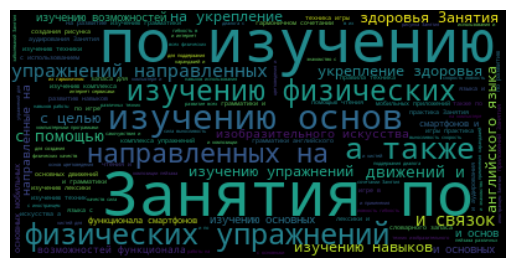

In [146]:
# Create full word text
full_text = ' '
for desc in groups.description.values:
    full_text = full_text + ' ' + desc

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50).generate(full_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [147]:
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words = stop_words + ['занятие', 'также', 'изучение']
morph = pymorphy2.MorphAnalyzer()

def sent_to_tokens(sentence):
    tokens = razdel.tokenize(sentence)
    tokens = [_.text.lower() for _ in tokens]
    final_tokens = []
    for token in tokens:
        if len(token) > 2 and not all([char.isdigit() for char in token]):
            parsed_token = morph.parse(token)[0]
            if parsed_token.normal_form not in stop_words and parsed_token.normal_form not in punctuation:
                token = str(parsed_token.normal_form)
                final_tokens.append(token)
    return final_tokens

groups['desc_tokens'] = groups['description'].progress_apply(sent_to_tokens)

  0%|          | 0/27003 [00:00<?, ?it/s]

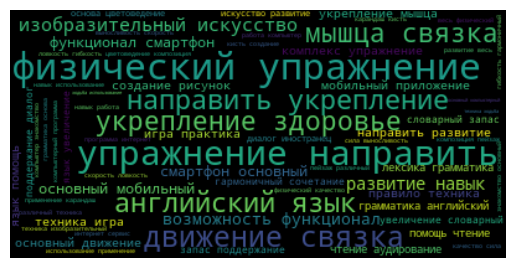

In [148]:
# Create full word text
full_text = ' '
for desc in groups.desc_tokens.values:
    desc = ' '.join(desc)
    full_text = full_text + ' ' + desc

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50).generate(full_text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [149]:
# Compute bigrams.
from gensim.models import Phrases
from gensim.models import CoherenceModel

# Add bigrams to docs (only ones that appear 30 times or more).
bigram = Phrases(groups['desc_tokens'], min_count=30)
for idx in range(len(groups['desc_tokens'])):
    for token in bigram[groups['desc_tokens'][idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            groups['desc_tokens'][idx].append(token)

In [150]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# Create a dictionary representation of the documents.
dictionary = Dictionary(groups['desc_tokens'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.6)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in groups['desc_tokens'].values]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 953
Number of documents: 27003


In [151]:
# Set training parameters.
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    coherence_values = []
    model_list = []

    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha='auto',
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
limit=60
start=46
step=2

model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus,
                                                        texts=groups['desc_tokens'],
                                                        start=start,
                                                        step=step,
                                                        limit=limit)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [64]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 46  has Coherence Value of 0.3877
Num Topics = 48  has Coherence Value of 0.4037
Num Topics = 50  has Coherence Value of 0.4411
Num Topics = 52  has Coherence Value of 0.4232
Num Topics = 54  has Coherence Value of 0.4609
Num Topics = 56  has Coherence Value of 0.4347
Num Topics = 58  has Coherence Value of 0.4197


In [152]:
# Set training parameters.
chunksize = 2000
passes = 20
iterations = 400
num_topics = 54
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

lda_model.print_topics()

[(13,
  '0.001*"замысел" + 0.001*"общение" + 0.001*"академический" + 0.001*"русский" + 0.001*"основной" + 0.001*"свет" + 0.001*"общество" + 0.001*"закалять" + 0.001*"орган" + 0.001*"профессиональный"'),
 (37,
  '0.299*"использование" + 0.101*"движение" + 0.101*"упражнение" + 0.101*"физический" + 0.101*"простой" + 0.101*"хореографический" + 0.101*"простой_хореографический" + 0.049*"арабский" + 0.000*"структура" + 0.000*"общество"'),
 (28,
  '0.082*"жанр" + 0.082*"история" + 0.079*"одежда" + 0.075*"развитие" + 0.050*"кинематограф_рождаться" + 0.050*"рождаться" + 0.050*"экран" + 0.050*"экран_изменяться" + 0.050*"изменяться" + 0.050*"герой"'),
 (33,
  '0.076*"здоровье" + 0.076*"поддержание" + 0.075*"психологический" + 0.073*"жизненный" + 0.072*"физический" + 0.071*"правило" + 0.071*"здоровый" + 0.071*"питание" + 0.071*"программа" + 0.071*"поиск_жизненный"'),
 (42,
  '0.339*"исторический" + 0.312*"культурный" + 0.069*"город" + 0.026*"россия" + 0.024*"московский" + 0.024*"история" + 0.024*"м

In [153]:
def get_topic(sentence):
    topic_probabilities = lda_model.get_document_topics(dictionary.doc2bow(sentence), minimum_probability=0.0)
    sorted_by_prob = sorted(topic_probabilities, key=lambda tup: tup[1], reverse=True)
    return sorted_by_prob[0][0]

groups['topic'] = groups['desc_tokens'].apply(get_topic)

In [154]:
groups = groups[['group_id', 'category 1', 'category 2', 'name', 'district', 'region',
                 'merged_shedule', 'street', 'home', 'online', 'description', 'marker', 'topic',]]

In [155]:
def get_shedule(list_shedule):
    shedule = [v.strip().replace(".", "")  for v in list_shedule[1:] if v.strip() != 'без перерыва']
    if shedule:
        if len(shedule[0]) == 2:
            shedule[0] = shedule[0] + shedule[1][2:]
        if 'перерыв 10 минут' in shedule:
            shedule = shedule[0]
        shedule = [v.split(' ') for v in shedule]
    else:
        shedule = np.nan
    return shedule

In [156]:
def get_new_shedule_features(shedule_list):
    shedule_features = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
    weekday_dict = {'Пн': 0,
                    'Вт': 1,
                    'Ср': 2,
                    'Чт': 3,
                    'Пт': 4,
                    'Сб': 5,
                    'Вс': 6}
    if shedule_list is not np.nan:
        if len(shedule_list) == 1:
            shedule_features = shedule_list[0]
            shedule_features = \
                [weekday_dict[shedule_features[0]]] +  [pd.to_datetime(time) for time in shedule_features[1].split('-')]
            shedule_features.append((shedule_features[-1] - shedule_features[-2]) / timedelta(hours=1))
            shedule_features[-2] = shedule_features[-2].hour
            shedule_features[-3] = shedule_features[-3].hour
            shedule_features += [np.nan, np.nan, np.nan, np.nan]
        elif len(shedule_list) == 2:
            shedule_features = shedule_list[0] + shedule_list[1]
            shedule_features_part1 = \
                [weekday_dict[shedule_features[0]]] +  [pd.to_datetime(time) for time in shedule_features[1].split('-')]
            shedule_features_part1.append((shedule_features_part1[-1] - shedule_features_part1[-2]) / timedelta(hours=1))
            shedule_features_part1[-2] = shedule_features_part1[-2].hour
            shedule_features_part1[-3] = shedule_features_part1[-3].hour
            shedule_features_part2 = \
                [weekday_dict[shedule_features[2]]] +  [pd.to_datetime(time) for time in shedule_features[3].split('-')]
            shedule_features_part2.append((shedule_features_part2[-1] - shedule_features_part2[-2])/ timedelta(hours=1))
            shedule_features_part2[-2] = shedule_features_part2[-2].hour
            shedule_features_part2[-3] = shedule_features_part2[-3].hour
            shedule_features = shedule_features_part1 + shedule_features_part2

    return shedule_features

groups['active_shedule'] = groups['merged_shedule'].str.split(';').apply(lambda x: x[0]).str.split(',').progress_apply(get_shedule)
new_shedule_features = groups['active_shedule'].progress_apply(get_new_shedule_features)
groups[['weekday_1', 'start_hour_1', 'finish_hour_1', 'delta_1',
        'weekday_2', 'start_hour_2', 'finish_hour_2', 'delta_2']] = \
    pd.DataFrame(new_shedule_features.tolist(), index= groups.index)

  0%|          | 0/27003 [00:00<?, ?it/s]

  0%|          | 0/27003 [00:00<?, ?it/s]

In [157]:
groups.head()

,group_id,category 1,category 2,name,district,region,merged_shedule,street,home,online,...,topic,active_shedule,weekday_1,start_hour_1,finish_hour_1,delta_1,weekday_2,start_hour_2,finish_hour_2,delta_2
0,801357270,Физическая активность,ОФП,ОФП,юго-восточный административный округ,муниципальный округ текстильщики,"c 01.01.2023 по 31.03.2023, Пн., Ср. 19:10-20:...",саратовская улица,дом 16,False,...,53,"[[Пн, 19:10-20:10], [Ср, 19:10-20:10]]",0.0,19.0,20.0,1.0,2.0,19.0,20.0,1.0
1,801356857,Физическая активность,ОФП,ОФП,юго-восточный административный округ,муниципальный округ марьино,"c 09.01.2023 по 31.03.2023, Вт., Чт. 10:00-11:...",подольская улица,дом 5,False,...,53,"[[Вт, 10:00-11:00], [Чт, 10:00-11:00]]",1.0,10.0,11.0,1.0,3.0,10.0,11.0,1.0
2,801351684,Физическая активность,ОФП,ОФП,северный административный округ,муниципальный округ западное дегунино,"c 09.01.2023 по 31.03.2023, Вт., Чт. 19:00-20:...",базовская улица,дом 15,False,...,53,"[[Вт, 19:00-20:00], [Чт, 19:00-20:00]]",1.0,19.0,20.0,1.0,3.0,19.0,20.0,1.0
3,801353683,Физическая активность,ОФП,ОФП,юго-западный административный округ,муниципальный округ обручевский,"c 09.01.2023 по 31.03.2023, Пн., Ср. 13:30-14:...",улица обручева,дом 28а,False,...,53,"[[Пн, 13:30-14:30], [Ср, 13:30-14:30]]",0.0,13.0,14.0,1.0,2.0,13.0,14.0,1.0
4,801352164,Физическая активность,ОФП,ОФП,юго-западный административный округ,муниципальный округ обручевский,"c 10.01.2023 по 28.02.2023, Вт., Пт. 12:00-13:...",воронцовский парк,дом 3,False,...,53,"[[Вт, 12:00-13:00], [Пт, 12:00-13:00]]",1.0,12.0,13.0,1.0,4.0,12.0,13.0,1.0


In [158]:
# Дополняем данные по округам и районам в groups и users

districts = [('cao', 'центральный административный округ'),
             ('sao', 'северный административный округ'),
             ('svao', 'северо-восточный административный округ'),
             ('vao', 'восточный административный округ'),
             ('uvao', 'юго-восточный административный округ'),
             ('uao', 'южный административный округ'),
             ('uzao', 'юго-западный административный округ'),
             ('zao', 'западный административный округ'),
             ('szao', 'северо-западный административный округ'),
             ('zelao', 'зеленоградский административный округ')]

regions = [('akademicheskij', 'академический'),
           ('alekseevskij', 'алексеевский'),
           ('altufevskij', 'алтуфьевский'),
           ('arbat', 'арбат'),
           ('aeroport', 'аэропорт'),
           ('babushkinskij', 'бабушкинский'),
           ('basmannyj', 'басманный'),
           ('begovoj', 'беговой'),
           ('beskudnikovskij', 'бескудниковский'),
           ('bibirevo', 'бибирево'),
           ('biryulevo_vostochnoe', 'бирюлево восточное'),
           ('biryulevo_zapadnoe', 'бирюлево западное'),
           ('bogorodskoe', 'богородское'),
           ('brateevo', 'братеево'),
           ('butovo_severnoe', 'бутово северное'),
           ('butovo_yuzhnoe', 'бутово южное'),
           ('butyrskij', 'бутырский'),
           ('veshnyaki', 'вешняки'),
           ('vnukovo', 'внуково'),
           ('vojkovskij', 'войковский'),
           ('vostochnyj', 'восточный'),
           ('vyhino-zhulebino', 'выхино-жулебино'),
           ('gagarinskij', 'гагаринский'),
           ('golovinskij', 'головинский'),
           ('golyanovo', 'гольяново'),
           ('danilovskij', 'даниловский'),
           ('degunino_vostochnoe', 'восточное дегунино'),
           ('degunino_zapadnoe', 'западное дегунино'),
           ('dmitrovskij', 'дмитровский'),
           ('donskoj', 'донской'),
           ('dorogomilovo', 'дорогомилово'),
           ('zamoskvoreche', 'замоскворечье'),
           ('zyuzino', 'зюзино'),
           ('zyablikovo', 'зябликово'),
           ('ivanovskoe', 'ивановское'),
           ('izmajlovo', 'измайлово'),
           ('izmajlovo_vostochnoe', 'измайлово восточное'),
           ('izmajlovo_severnoe', 'северное измайлово'),
           ('kapotnya', 'капотня'),
           ('konkovo', 'коньково'),
           ('koptevo', 'коптево'),
           ('kosino-uhtomskij', 'косино-ухтоминский'),
           ('kotlovka', 'котловка'),
           ('krasnoselskij', 'красносельский'),
           ('krylatskoe', 'крылатское'),
           ('kryukovo', 'крюково'),
           ('kuzminki', 'кузьминки'),
           ('kuncevo', 'кунцево'),
           ('kurkino', 'куркино'),
           ('levoberezhnyj', 'левобережный'),
           ('lefortovo', 'лефортово'),
           ('lianozovo', 'лианозово'),
           ('lomonosovskij', 'ломоносовский'),
           ('losinoostrovskij', 'лосиноостровский'),
           ('lyublino', 'люблино'),
           ('marfino', 'марфино'),
           ('marina_roshcha', 'марьина роща'),
           ('marino', 'марьино'),
           ('matushkino', 'матушкино'),
           ('medvedkovo_severnoe', 'северное медведково'),
           ('medvedkovo_yuzhnoe', 'южное медведково'),
           ('metrogorodok', 'метрогородок'),
           ('meshchanskij', 'мещанский'),
           ('mitino', 'митино'),
           ('mozhajskij', 'можайский'),
           ('molzhaninovskij', 'молжаниновский'),
           ('moskvoreche-saburovo', 'москворечье-сабурово'),
           ('nagatino-sadovniki', 'нагатино-садовники'),
           ('nagatinskij_zaton', 'нагатинский затон'),
           ('nagornyj', 'нагорный'),
           ('nekrasovka', 'некрасовка'),
           ('nizhegorodskij', 'нижегородский'),
           ('novo-peredelkino', 'ново-переделкино'),
           ('novogireevo', 'новогиреево'),
           ('novokosino', 'новокосино'),
           ('obruchevskij', 'обручевский'),
           ('orehovo-borisovo_severnoe', 'орехово-борисово северное'),
           ('orehovo-borisovo_yuzhnoe', 'орехово-борисово южное'),
           ('ostankinskij', 'останкинский'),
           ('otradnoe', 'отрадное'),
           ('ochakovo-matveevskoe', 'очаково-матвеевское'),
           ('perovo', 'перово'),
           ('pechatniki', 'печатники'),
           ('pokrovskoe-streshnevo', 'покровское-стрешнево'),
           ('preobrazhenskoe', 'преображенское'),
           ('presnenskij', 'пресненский'),
           ('prospekt_vernadskogo', 'проспект вернадского'),
           ('ramenki', 'раменки'),
           ('rostokino', 'ростокино'),
           ('ryazanskij', 'рязанский'),
           ('savelki', 'савелки'),
           ('savelovskij', 'савеловский'),
           ('sviblovo', 'свиблово'),
           ('severnyj', 'северный'),
           ('silino', 'силино'),
           ('sokol', 'сокол'),
           ('sokolinaya_gora', 'соколиная гора'),
           ('sokolniki', 'сокольники'),
           ('solncevo', 'солнцево'),
           ('staroe_kryukovo', 'старое крюково'),
           ('strogino', 'строгино'),
           ('taganskij', 'таганский'),
           ('tverskoj', 'тверской'),
           ('tekstilshchiki', 'текстильщики'),
           ('teplyj_stan', 'теплый стан'),
           ('timiryazevskij', 'тимирязевский'),
           ('troparevo-nikulino', 'тропарево-никулино'),
           ('tushino_severnoe', 'северное тушино'),
           ('tushino_yuzhnoe', 'южное тушино'),
           ('filevskij_park', 'филевский парк'),
           ('fili-davydkovo', 'фили-давыдково'),
           ('hamovniki', 'хамовники'),
           ('hovrino', 'ховрино'),
           ('horoshevo-mnevniki', 'хорошего-мневники'),
           ('horoshevskij', 'хорошевский'),
           ('caricyno', 'царицыно'),
           ('cheremushki', 'черемушки'),
           ('chertanovo_severnoe', 'северное чертаново'),
           ('chertanovo_centralnoe', 'центральное чертаново'),
           ('chertanovo_yuzhnoe', 'чертаново южное'),
           ('shchukino', 'щукино'),
           ('yuzhnoportovyj', 'южнопортовый'),
           ('yakimanka', 'якиманка'),
           ('yaroslavskij', 'ярославский'),
           ('yasenevo', 'ясенево')]

district_pages = []
for district in districts:
    district_url = f'http://mosopen.ru/district/{district[0]}/streets'
    r = requests.get(district_url)
    text = r.text.lower()
    district_pages.append(text)

region_pages = []
for region in regions:
    region_url = f'http://mosopen.ru/region/{region[0]}/streets'
    r = requests.get(region_url)
    text = r.text.lower()
    region_pages.append(text)

def get_district(street):
    district_name = np.nan
    street = re.sub('(улица|квартал|бульвар|проезд|мост|шоссе|пр-т|проспект|парк|переулок|пер\.|линия|пр-д|наб\.|набережная|пр\.|б-р|ул\.|пр-кт|ш\.|ак\.|мкр\.|микрорайон|булв\.|дом|д\.|р-н|г\.|пр-д|мкр-н|м-н)', '', street)
    street = street.strip()
    for i, district in enumerate(districts):
        if street in district_pages[i]:
            district_name = district[1]
            break
    return district_name

def get_region(street):
    region_name = np.nan
    street = re.sub('(улица|квартал|бульвар|проезд|мост|шоссе|пр-т|проспект|парк|переулок|пер\.|линия|пр-д|наб\.|набережная|пр\.|б-р|ул\.|пр-кт|ш\.|ак\.|мкр\.|микрорайон|булв\.|дом|д\.|р-н|г\.|пр-д|мкр-н|м-н)', '', street)
    street = street.strip()
    for i, region in enumerate(regions):
        if street in region_pages[i]:
            region_name = region[1]
            break
    return region_name

In [159]:
groups.loc[(groups['district'].isna() & ~groups['street'].isna()), 'district'] = \
    groups.loc[(groups['district'].isna() & ~groups['street'].isna()), 'street'].apply(get_district)

groups.loc[(groups['region'].isna() & ~groups['street'].isna()), 'region'] = \
    groups.loc[(groups['region'].isna() & ~groups['street'].isna()), 'street'].apply(get_region)

In [160]:
users['district'] = users['street'].progress_apply(get_district)
users['region'] = users['street'].progress_apply(get_region)

  0%|          | 0/52334 [00:00<?, ?it/s]

  0%|          | 0/52334 [00:00<?, ?it/s]

In [161]:
district_pages = []
region_pages = []

In [162]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   group_id        27003 non-null  int64  
 1   category 1      27003 non-null  object 
 2   category 2      27003 non-null  object 
 3   name            27003 non-null  object 
 4   district        24939 non-null  object 
 5   region          24939 non-null  object 
 6   merged_shedule  27003 non-null  object 
 7   street          27003 non-null  object 
 8   home            26936 non-null  object 
 9   online          27003 non-null  bool   
 10  description     27003 non-null  object 
 11  marker          27003 non-null  object 
 12  topic           27003 non-null  int64  
 13  active_shedule  26955 non-null  object 
 14  weekday_1       26947 non-null  float64
 15  start_hour_1    26947 non-null  float64
 16  finish_hour_1   26947 non-null  float64
 17  delta_1         26947 non-null 

In [163]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52334 entries, 0 to 52333
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            52334 non-null  int64 
 1   registration_date  52334 non-null  object
 2   birthday_date      52334 non-null  object
 3   sex                52334 non-null  int64 
 4   street             52334 non-null  object
 5   home               52330 non-null  object
 6   reg_year           52334 non-null  int32 
 7   reg_month          52334 non-null  int32 
 8   birthday_year      52334 non-null  int32 
 9   birthday_month     52334 non-null  int32 
 10  age                52334 non-null  int64 
 11  active_in_months   52334 non-null  int64 
 12  active_in_years    52334 non-null  int64 
 13  district           45894 non-null  object
 14  region             45894 non-null  object
dtypes: int32(4), int64(5), object(6)
memory usage: 5.2+ MB


In [164]:
streets_without_district_and_region = groups[groups['region'].isna() | groups['district'].isna()]['street'].unique().tolist() + \
                                      users[users['region'].isna() | users['district'].isna()]['street'].unique().tolist()
streets_with_district_and_region = groups[~groups['region'].isna() & ~groups['district'].isna()]['street'].unique().tolist() + \
                                   users[~users['region'].isna() & ~users['district'].isna()]['street'].unique().tolist()

In [165]:
# расстояние левинштейна для заполнения пропусков
street_dict = {}
for street_without in streets_without_district_and_region:
    candidates = []
    for street_with in streets_with_district_and_region:
        score = fuzz.token_sort_ratio(street_without, street_with)
        if score > 76:
            candidates.append((street_with, score))
        if score == 100:
            break
    if candidates:
        candidates = sorted(candidates, key=lambda tup: tup[1], reverse=True)
        street_dict[street_without] = candidates[0][0]

In [166]:
groups['street'].replace(street_dict, inplace=True)
users['street'].replace(street_dict, inplace=True)

ref_groups = groups[['street', 'region']]
ref_users = users[['street', 'region']]
ref = pd.concat([ref_groups, ref_users], ignore_index=True)
ref.sort_values("region", inplace=True)
region_ref = ref.groupby('street')['region'].first()

groups['region'] = groups['region'].fillna(groups['street'].map(region_ref))
users['region'] = users['region'].fillna(users['street'].map(region_ref))

In [167]:
groups['street'].replace(street_dict, inplace=True)
users['street'].replace(street_dict, inplace=True)

ref_groups = groups[['street', 'district']]
ref_users = users[['street', 'district']]
ref = pd.concat([ref_groups, ref_users], ignore_index=True)
ref.sort_values("district", inplace=True)
district_ref = ref.groupby('street')['district'].first()

groups['district'] = groups['district'].fillna(groups['street'].map(district_ref))
users['district'] = users['district'].fillna(users['street'].map(district_ref))

In [168]:
# унификация названий районов
groups.loc[~groups['region'].isna(), 'region'] = \
    groups.loc[~groups['region'].isna(), 'region'].apply(lambda x: x[20:] if 'муниципальный округ' in x or
                                                                             'муниципальное образование' in x else x)
users.loc[~users['region'].isna(), 'region'] = \
    users.loc[~users['region'].isna(), 'region'].apply(lambda x: x[20:] if 'муниципальный округ' in x or
                                                                           'муниципальное образование' in x else x)

In [169]:
groups.drop(columns=['merged_shedule'], inplace=True) # удалить лишние столбцы

In [170]:
attend.rename(columns={'уникальный номер занятия': 'lesson_id', 'уникальный номер группы': 'group_id', 'уникальный номер участника': 'user_id', 'дата занятия': 'lesson_date', 'время начала занятия': 'start_time', 'время окончания занятия': 'finish_time'}, inplace=True)
attend = attend[['lesson_id', 'group_id', 'user_id', 'lesson_date', 'start_time', 'finish_time']]

In [171]:
attend['lesson_date'] = pd.to_datetime(attend['lesson_date'])
attend['lesson_weekday'] = attend['lesson_date'].dt.weekday

In [172]:
attend['start_time'] = pd.to_datetime(attend['start_time'])
attend['finish_time'] = pd.to_datetime(attend['finish_time'])
attend['delta'] = attend['finish_time'] - attend['start_time']
attend['delta'] = attend['delta'].apply(lambda x: x / timedelta(hours=1))
attend['start_hour'] = attend['start_time'].apply(lambda x: x.time().hour)
attend['finish_hour'] = attend['finish_time'].apply(lambda x: x.time().hour)

C:\Users\Strix\AppData\Local\Temp\ipykernel_26460\2245795831.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  attend['start_time'] = pd.to_datetime(attend['start_time'])
C:\Users\Strix\AppData\Local\Temp\ipykernel_26460\2245795831.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  attend['finish_time'] = pd.to_datetime(attend['finish_time'])


In [173]:
attend.head()

,lesson_id,group_id,user_id,lesson_date,start_time,finish_time,lesson_weekday,delta,start_hour,finish_hour
0,401346550,801346550,101352023,2022-08-01,2023-05-26 09:00:00,2023-05-26 10:00:00,0,1.0,9,10
1,401346550,801346550,101385462,2022-08-01,2023-05-26 09:00:00,2023-05-26 10:00:00,0,1.0,9,10
2,401346550,801346550,101421897,2022-08-01,2023-05-26 09:00:00,2023-05-26 10:00:00,0,1.0,9,10
3,401346550,801346550,101354499,2022-08-01,2023-05-26 09:00:00,2023-05-26 10:00:00,0,1.0,9,10
4,401346550,801346550,101421312,2022-08-01,2023-05-26 09:00:00,2023-05-26 10:00:00,0,1.0,9,10


In [174]:
users.rename(
    columns={'street': 'user_street', 'home': 'user_home', 'region': 'user_region', 'district': 'user_district'}, inplace=True)

In [175]:
# анализ уникальных групп и пользователей
def count_fkey(key1, key2):
    un1 = np.unique(key1)
    un2 = key2
    cm = np.in1d(un1, un2, assume_unique=True)
    if 'name' in dir(key1):
        print(f"Unique [{key1.name}]: { un1.size}")
        print(f"Unique [{key2.name}]: { np.unique(un2).size}")
    else:
        print(f"key1: { un1.size}")
        print(f"key2: { un2.size}")
    c = np.unique(cm, return_counts=True)
    print(pd.DataFrame({'values':c[0], 'count':c[1]}))

print(count_fkey(users.user_id, attend.user_id))
print(count_fkey(groups.group_id, attend.group_id))

Unique [user_id]: 52334
Unique [user_id]: 50906
   values  count
0   False   1428
1    True  50906
None
Unique [group_id]: 27003
Unique [group_id]: 24535
   values  count
0   False   2468
1    True  24535
None


In [176]:
users = users[users['user_id'].isin(attend['user_id'])]

In [178]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   group_id        27003 non-null  int64  
 1   category 1      27003 non-null  object 
 2   category 2      27003 non-null  object 
 3   name            27003 non-null  object 
 4   district        26569 non-null  object 
 5   region          26569 non-null  object 
 6   street          27003 non-null  object 
 7   home            26936 non-null  object 
 8   online          27003 non-null  bool   
 9   description     27003 non-null  object 
 10  marker          27003 non-null  object 
 11  topic           27003 non-null  int64  
 12  active_shedule  26955 non-null  object 
 13  weekday_1       26947 non-null  float64
 14  start_hour_1    26947 non-null  float64
 15  finish_hour_1   26947 non-null  float64
 16  delta_1         26947 non-null  float64
 17  weekday_2       17186 non-null 

In [179]:
groups.loc[groups['group_id'] == 801354139, 'active_shedule'] = "[['Вт', '10:50-13:30']]"
groups.loc[groups['group_id'] == 801373584, 'active_shedule'] = "[['Вт', '11:00-13:15'], ['Пт', '11:00-13:15']]"
groups.loc[groups['group_id'] == 801362030, 'active_shedule'] = "[['Пн', '06:00-22:00'], ['Ср', '06:00-22:00']]"
groups.loc[groups['group_id'] == 801373704, 'active_shedule'] = "[['Пн', '06:00-22:00'], ['Ср', '06:00-22:00']]"
groups.loc[groups['group_id'] == 801353947, 'active_shedule'] = "[['Пн', '10:30-12:30'], ['Ср', '10:30-12:30']]"
groups.loc[groups['group_id'] == 801354781, 'active_shedule'] = "[['Пн', '14:15-16:15'], ['Ср', '14:15-16:15']]"
groups.loc[groups['group_id'] == 801358897, 'active_shedule'] = "[['Пн', '16:00-18:00'], ['Чт', '16:00-18:00']]"
groups.loc[groups['group_id'] == 801364900, 'active_shedule'] = "[['Пн', '16:00-18:00'], ['Чт', '16:00-18:00']]"

groups.loc[groups['group_id'] == 801354139, 'weekday_1'] = 1
groups.loc[groups['group_id'] == 801373584, 'weekday_1'] = 1
groups.loc[groups['group_id'] == 801362030, 'weekday_1'] = 0
groups.loc[groups['group_id'] == 801373704, 'weekday_1'] = 0
groups.loc[groups['group_id'] == 801353947, 'weekday_1'] = 0
groups.loc[groups['group_id'] == 801354781, 'weekday_1'] = 0
groups.loc[groups['group_id'] == 801358897, 'weekday_1'] = 0
groups.loc[groups['group_id'] == 801364900, 'weekday_1'] = 0

groups.loc[groups['group_id'] == 801354139, 'start_hour_1'] = 10
groups.loc[groups['group_id'] == 801373584, 'start_hour_1'] = 11
groups.loc[groups['group_id'] == 801362030, 'start_hour_1'] = 6
groups.loc[groups['group_id'] == 801373704, 'start_hour_1'] = 6
groups.loc[groups['group_id'] == 801353947, 'start_hour_1'] = 10
groups.loc[groups['group_id'] == 801354781, 'start_hour_1'] = 14
groups.loc[groups['group_id'] == 801358897, 'start_hour_1'] = 16
groups.loc[groups['group_id'] == 801364900, 'start_hour_1'] = 16

groups.loc[groups['group_id'] == 801354139, 'finish_hour_1'] = 13
groups.loc[groups['group_id'] == 801373584, 'finish_hour_1'] = 13
groups.loc[groups['group_id'] == 801362030, 'finish_hour_1'] = 22
groups.loc[groups['group_id'] == 801373704, 'finish_hour_1'] = 22
groups.loc[groups['group_id'] == 801353947, 'finish_hour_1'] = 12
groups.loc[groups['group_id'] == 801354781, 'finish_hour_1'] = 16
groups.loc[groups['group_id'] == 801358897, 'finish_hour_1'] = 18
groups.loc[groups['group_id'] == 801364900, 'finish_hour_1'] = 18

groups.loc[groups['group_id'] == 801354139, 'delta_1'] = 2
groups.loc[groups['group_id'] == 801373584, 'delta_1'] = 2
groups.loc[groups['group_id'] == 801362030, 'delta_1'] = 16
groups.loc[groups['group_id'] == 801373704, 'delta_1'] = 16
groups.loc[groups['group_id'] == 801353947, 'delta_1'] = 2
groups.loc[groups['group_id'] == 801354781, 'delta_1'] = 2
groups.loc[groups['group_id'] == 801358897, 'delta_1'] = 2
groups.loc[groups['group_id'] == 801364900, 'delta_1'] = 2

groups.loc[groups['group_id'] == 801354139, 'weekday_2'] = np.nan
groups.loc[groups['group_id'] == 801373584, 'weekday_2'] = 0
groups.loc[groups['group_id'] == 801362030, 'weekday_2'] = 2
groups.loc[groups['group_id'] == 801373704, 'weekday_2'] = 2
groups.loc[groups['group_id'] == 801353947, 'weekday_2'] = 2
groups.loc[groups['group_id'] == 801354781, 'weekday_2'] = 2
groups.loc[groups['group_id'] == 801358897, 'weekday_2'] = 3
groups.loc[groups['group_id'] == 801364900, 'weekday_2'] = 3

groups.loc[groups['group_id'] == 801354139, 'start_hour_2'] = np.nan
groups.loc[groups['group_id'] == 801373584, 'start_hour_2'] = 11
groups.loc[groups['group_id'] == 801362030, 'start_hour_2'] = 6
groups.loc[groups['group_id'] == 801373704, 'start_hour_2'] = 6
groups.loc[groups['group_id'] == 801353947, 'start_hour_2'] = 10
groups.loc[groups['group_id'] == 801354781, 'start_hour_2'] = 14
groups.loc[groups['group_id'] == 801358897, 'start_hour_2'] = 16
groups.loc[groups['group_id'] == 801364900, 'start_hour_2'] = 16

groups.loc[groups['group_id'] == 801354139, 'finish_hour_2'] = np.nan
groups.loc[groups['group_id'] == 801373584, 'finish_hour_2'] = 13
groups.loc[groups['group_id'] == 801362030, 'finish_hour_2'] = 22
groups.loc[groups['group_id'] == 801373704, 'finish_hour_2'] = 22
groups.loc[groups['group_id'] == 801353947, 'finish_hour_2'] = 12
groups.loc[groups['group_id'] == 801354781, 'finish_hour_2'] = 16
groups.loc[groups['group_id'] == 801358897, 'finish_hour_2'] = 18
groups.loc[groups['group_id'] == 801364900, 'finish_hour_2'] = 18

groups.loc[groups['group_id'] == 801354139, 'delta_2'] = np.nan
groups.loc[groups['group_id'] == 801373584, 'delta_2'] = 2
groups.loc[groups['group_id'] == 801362030, 'delta_2'] = 16
groups.loc[groups['group_id'] == 801373704, 'delta_2'] = 16
groups.loc[groups['group_id'] == 801353947, 'delta_2'] = 2
groups.loc[groups['group_id'] == 801354781, 'delta_2'] = 2
groups.loc[groups['group_id'] == 801358897, 'delta_2'] = 2
groups.loc[groups['group_id'] == 801364900, 'delta_2'] = 2

In [180]:
group_street_to_r_d = {
    'ул. 1-ая парковая д. 12': ['измайлово', 'восточный административный округ'],
    'ул.молостовых дом 17': ['ивановское', 'восточный административный округ'],
    'пос.воскресенское дом 40': [np.nan, 'троицкий и новомосковский административные округа'],
    'г. краснодар': [np.nan, np.nan]
}

groups.loc[~groups['street'].isna() & groups['region'].isna(), 'region'] = groups[~groups['street'].isna() & groups['region'].isna()].street.apply(lambda x: group_street_to_r_d[x][0]
                                                                        if x in group_street_to_r_d.keys() else np.nan)

groups.loc[~groups['street'].isna() & groups['district'].isna(), 'district'] = groups[~groups['street'].isna() & groups['district'].isna()].street.apply(lambda x: group_street_to_r_d[x][1]
if x in group_street_to_r_d.keys() else np.nan)

In [181]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   group_id        27003 non-null  int64  
 1   category 1      27003 non-null  object 
 2   category 2      27003 non-null  object 
 3   name            27003 non-null  object 
 4   district        26603 non-null  object 
 5   region          26593 non-null  object 
 6   street          27003 non-null  object 
 7   home            26936 non-null  object 
 8   online          27003 non-null  bool   
 9   description     27003 non-null  object 
 10  marker          27003 non-null  object 
 11  topic           27003 non-null  int64  
 12  active_shedule  26955 non-null  object 
 13  weekday_1       26955 non-null  float64
 14  start_hour_1    26955 non-null  float64
 15  finish_hour_1   26955 non-null  float64
 16  delta_1         26955 non-null  float64
 17  weekday_2       17193 non-null 

In [182]:
street_to_r_d = {
    '4-й вятский пер.': ['савеловский', 'северный административный округ'],
    'вертолетчиков': ['некрасовка', 'юго-восточный административный округ'],
    'квартал самаркандский бульвар 137а': ['выхино-жулебино', 'юго-восточный административный округ'],
    '1-я бебеля': ['савеловский', 'северный административный округ'],
    '2-ая рейсовая ': ['внуково', 'западный административный округ'],
    'индустриальная ул.': ['красносельский', 'центральный административный округ'],
    '1-я дубровская': ['таганский', 'центральный административный округ'],
    '3-я фрунзенская улица': ['хамовники', 'центральный административный округ'],
    'киевское ш-се 23 км': ['внуково', 'западный административный округ'],
    '3-я богатырская': ['богородское', 'восточный административный округ'],
    'вишневая': ['покровское-стрешнево', 'северо-западный административный округ'],
    'улица александры монаховой': ['', 'новомосковский административный округ'],
    '38 квартал юго-запада': ['обручевский', 'юго-западный административный округ'],
    'высотная ул.': ['люблино', 'юго-восточный административный округ'],
    '6-1 новоподмосковный': ['войсковой', 'северный административный округ'],
    '3-я филевская': ['филевский парк', 'западный административный округ'],
    '3 прядильная': ['измайлово', 'восточный административный округ'],
    'б. каменщики': ['таганский', 'центральный административный округ'],
    'кашенкин луг': ['марфино', 'северо-восточный административный округ'],
    'кадомцева проезд': ['ростокино', 'северо-восточный административный округ'],
    '4-вятский пер.': ['савеловский', 'северный административный округ'],
    'бульвар веласкеса': ['', 'новомосковский административный округ'],
    '1-й тверской-ямской переулок': ['тверской', 'центральный административный округ'],
    '1й краснокурсансткий проезд': ['лефортово', 'юго-восточный административный округ'],
    'симферопольская': ['зюзино', 'юго-западный административный округ'],
    '2 рейсовая ': ['внуково', 'западный административный округ'],
    'а. ахматовой': ['', 'новомосковский административный округ'],
    '3я институтская': ['рязанский', 'юго-восточный административный округ'],
    'ул. бианки': ['', 'новомосковский административный округ'],
    '1-ый павловский пер.': ['даниловский', 'южный административный округ'],
    '1-й новокузнецкий переулок': ['замоскворечье', 'центральный административный округ'],
    '2-я бебеля': ['савеловский', 'северный административный округ'],
    '1-й коптельский пер': ['красносельский', 'центральный административный округ'],
    '3-й самотёчный переулок': ['тверской', 'центральный административный округ'],
    '1-ая новокузьминская': ['рязанский', 'юго-восточный административный округ'],
    ' улица юлиана семенова д. 8': ['солнцево', 'западный административный округ'],
    '1-ая напрудная': ['лосиноостровской', 'северо-восточный административный округ'],
    '3-й павелецкий пр.': ['даниловский', 'южный административный округ'],
    '4 вятский пер.': ['савеловский', 'северный административный округ'],
    '3-й балтийский переулок': ['аэропорт', 'северный административный округ'],
    '3-рыбинская': ['сокольники', 'восточный административный округ'],
    '6 радиальная': ['бирюлево восточное', 'южный административный округ'],
    '2-й полевой переулок': ['сокольники', 'восточный административный округ'],
    'ухтомского ополчения': ['некрасовка', 'юго-восточный административный округ'],
    'проектируемый проезд 1980': ['очаково-матвеевское', 'западный административный округ'],
    'пр-т защитников москвы': ['некрасовка', 'юго-восточный административный округ'],
    'территория ленинские горы': ['раменки', 'западный административный город'],
    '2-й грайвороновский проезд': ['рязанский', 'юго-восточный административный округ'],
    '4 новокузьминская': ['рязанский', 'юго-восточный административный округ'],
    'вертолётчиков': ['некрасовка', 'юго-восточный административный округ'],
    '1-ая вольская ': ['некрасовка', 'юго-восточный административный округ'],
    '4-й красносельский пер.': ['красносельский', 'центральный административный округ'],
    '2-ая владимирская': ['новогиреево', 'восточный административный округ'],
    'улица самуила маршака': ['ново-переделкино', 'западный административный округ'],
    'головачева': ['люблино', 'юго-восточный административный округ'],
    'десятинная': ['', 'троицкий административный округ'],
    '2-я миусская': ['тверской', 'центральный административный округ'],
    'восьмого марта': ['аэропорт', 'северный административный округ'],
    '2-й новый пер.': ['красносельский', 'центральный административный округ'],
    'б.козихинский пер.': ['пресненский', 'центральный административный округ'],
    '1-я боевская ': ['сокольники', 'восточный административный округ'],
    'улица анны ахматовой': ['', 'новомосковский административный округ'],
    'корнея чуковского': ['бибирево', 'северо-восточный административный округ'],
    '2-й переулок петра алексеева': ['можайский', 'западный административный округ'],
    '2-я улица бебеля': ['савеловский', 'северный административный округ'],
    'коммунарка': ['', 'новомосковский административный округ'],
    '2 синичкина': ['лефортово', 'юго-восточный административный округ'],
    '1-й нижний михайловский проезд': ['даниловский', 'южный административный округ'],
    '1-й краснокурсантский проезд': ['лефортово', 'юго-восточный административный округ'],
    'татарский м.': ['замоскваречье', 'центральный административный округ'],
    '1-й переулок тружеников': ['хамовники', 'центральный административный округ'],
    'перово поля 3й пр.': ['перово', 'восточный административный округ'],
    'улица корнея чуковского': ['бибирево', 'северо-восточный административный округ'],
    'б.филёвская': ['филевский парк', 'западный административный округ'],
    '4-й сыромятнический переулок': ['басманный', 'центральный административный округ'],
    '2-ая рейсовая': ['внуково', 'западный административный округ'],
    '2-й хвостов переулок': ['якименка', 'центральный административный округ'],
    'улица героя россии соломатина': ['', 'новомосковский административный округ'],
    '2-я брестская': ['пресненский', 'центральный административный округ'],
    '2-й балтийский переулок': ['аэропорт', 'северный административный округ'],
    '1-й кирпичный переулок': ['соколиная гора', 'восточный административный округ'],
    '2 -ой балтийский переулок': ['аэропорт', 'северный административный округ'],
    '1-я прядильная ': ['измайлово', 'восточный административный округ'],
    '2-ой полевой переулок': ['сокольники', 'восточный административный округ'],
    '2-ой павловский пер.': ['даниловский', 'южный административный округ'],
    'мостотреста': ['', 'новомосковский административный округ'],
    'кленово с.': ['', 'троицкий административный округ'],
    '2-я пятилетка': ['крюково', 'зеленоградский административный округ'],
    '2-й институтский проезд': ['рязанский', 'юго-восточный административный округ'],
    '1-й красносельский пер.': ['красносельский', 'центральный административный округ'],
    'б.черемушкинская': ['академический', 'юго-западный административный округ'],
    'юбилейная ул.': ['', 'троицкий административный округ'],
    '2-я квесисская': ['савеловский', 'северный административный округ'],
    '2-й верхний михайловский пр-д.': ['донский', 'южный административный округ'],
    '1-й самотечный пер.': ['тверской', 'центральный административный округ'],
    '1-я гражданская': ['богородское', 'восточный административный округ'],
    'б.трехгорный пер': ['пресненский', 'центральный административный округ'],
    'улица маршала ерёменко': ['некрасовка', 'юго-восточный административный округ'],
    'улица татьянин парк': ['', 'новомосковский административный округ'],
    '2-я филевская': ['филевский парк', 'западный административный округ'],
    'черное озеро': ['косино-ухтомский', 'восточный административный округ'],
    '1 прядильная': ['измайлово', 'восточный административный округ'],
    '1-я улица энтузиастов': ['перово', 'восточный административный округ'],
    '1 радиаторская': ['войковский', 'северный административный округ'],
    '2-я рощинская': ['даниловский', 'южный административный округ'],
    '1-я машиностроения': ['южнопортовый', 'юго-восточный административный округ'],
    'микрорайон "центральный"': ['орехово-борисово южное', 'южный административный округ'],
    '1 войковский': ['войковский', 'северный административный округ'],
    '4-й самотечный переулок': ['тверской', 'центральный административный округ'],
    '3-й проезд перова поля': ['перово', 'восточный административный округ'],
    '3ий дорожный ': ['чертаново южное', 'южный административный округ'],
    'город химки': ['левобережный', ''],
    '1-й смоленский пер.': ['арбат', 'центральный административный округ'],
    '2 хуторской': ['савеловский', 'северный административный округ'],
    'мкр эдальго': ['', 'новомосковский административный округ'],
    'симфиропольская': ['зюзино', 'юго-западный административный округ'],
    'физическая': ['кунцево', 'западный административный округ'],
    'а. солженицына': ['таганский', 'центральный административный округ'],
    '5 котельнический пер.': ['таганский', 'центральный административный округ'],
    'проспект генерала алексеева': ['силино', 'зеленоградский административный округ'],
    '1ая хуторская': ['савеловский', 'северный административный округ'],
    'симферопольская ул.': ['зюзино', 'юго-западный административный округ'],
    'верх. радищевская': ['таганский', 'центральный административный округ'],
    '3-я рыбинская': ['сокольники', 'восточный административный округ'],
    '4-й стрелецкий': ['марьина роща', 'северо-восточный административный округ'],
    '4-новокузьминская': ['рязанский', 'юго-восточный административный округ'],
    'самуила  маршака': ['ново-переделкино', 'западный административный округ'],
    '9 рота': ['преображенское', 'восточный административный округ'],
    '2-я улица бухвостова': ['преображенское', 'восточный административный округ'],
    '2-я боевская': ['сокольники', 'восточный административный округ'],
    'вертолетчиков ': ['некрасовка', 'юго-восточный административный округ'],
    'ск. мухиной': ['ново-переделкино', 'западный административный округ'],
    'улица ухтомского ополчения': ['некрасовка', 'юго-восточный административный округ'],
    'зеленый пр.': ['ивановское', 'восточный административный округ'],
    'м-н "в"': ['обручевский', 'юго-западный административный округ'],
    '2-й самотёчный переулок': ['тверской', 'центральный административный округ'],
    '1 новоподмосковный': ['войсковой', 'северный административный округ'],
    'подъемный пер': ['нижегородский', 'юго-восточный административный округ'],
    '1-й вражский пер': ['хамовники', 'центральный административный округ'],
    'полковника милиции курочкина': ['', 'троицкий административный округ'],
    '3 ул. марьина роща': ['марьина роща', 'северо-восточный административный округ'],
    'м. каменщики': ['таганский', 'центральный административный округ'],
    '2-ясиничкина': ['лефортово', 'юго-восточный административный округ'],
    '1-ый институтский проезд': ['рязанский', 'юго-восточный административный округ'],
    'улица лётчика ульянина': ['', 'новомосковский административный округ'],
    '2-лихачевский': ['савеловский', 'северный административный округ'],
    '1-й самотечный пер': ['тверской', 'центральный административный округ'],
    '1-ый краснокурсантский проезд': ['лефортово', 'юго-восточный административный округ'],
    '1-ая дубровская': ['таганский', 'центральный административный округ'],
    'квартал самаркандский бульвар 134а': ['выхино-жулебино', 'юго-восточный административный округ'],
    'красногорский район': ['красногорский', ''],
    'улица бориса пастернака': ['', 'новомосковский административный округ'],
    'б.девятинский пер.': ['арбат', 'центральный административный округ'],
    'кадомцева пр-д': ['ростокино', 'северо-восточный административный округ'],
    '3я радиаторская': ['войковский', 'северный административный округ'],
    'татьянин парк': ['', 'новомосковский административный округ'],
    '1 й войковский пр.': ['войковский', 'северный административный округ'],
    '3-я барышевская': ['митино', 'северо-западный административный округ'],
    '4й войковский пр.': ['войковский', 'северный административный округ'],
    '2-я фрунзенская улица': ['хамовники', 'центральный административный округ'],
    'ул. николо-хованская': ['', 'новомосковский административный округ'],
    '5-я соколиная гора': ['соколиная гора', 'восточный административный округ'],
    '4-ая гражданская': ['богородское', 'восточный административный округ'],
    '3-й павловский пер.': ['даниловский', 'южный административный округ'],
    'ул. летчика грицевца': ['', 'новомосковский административный округ'],
    '1-я улица бебеля': ['савеловский', 'северный административный округ'],
    '4я марьина роща': ['марьина роща', 'северо-восточный административный округ'],
    '2-й павелецкий проезд': ['даниловский', 'южный административный округ'],
    '1-ый спасоналивковский пер.': ['якиминка', 'центральный административный округ'],
    '1 я дубровская ': ['таганский', 'центральный административный округ'],
    '6-й красносельский пер.': ['красносельский', 'центральный административный округ'],
    '2-я машиностроения': ['печатники', 'юго-восточный административный округ'],
    '2я владимирская': ['новогиреево', 'восточный административный округ'],
    '4-й верхний михайловский проезд': ['донский', 'южный административный округ'],
    '2-й красносельский пер.': ['красносельский', 'центральный административный округ'],
    '1-й самотёчный переулок': ['тверской', 'центральный административный округ'],
    'зеленый пр-т': ['ивановское', 'восточный административный округ'],
    'а. петлякова': ['', 'новомосковский административный округ'],
    '2-я улица синичкина': ['лефортово', 'юго-восточный административный округ'],
    '3 дорожный ': ['чертаново южное', 'южный административный округ'],
    'аллея первой маёвки': ['вешняки', 'восточный административный округ'],
    'корабельная': ['лефортово', 'юго-восточный административный округ'],
    '5- ый рощинский пр.': ['даниловский', 'южный административный округ'],
    '2-я фрунзинская': ['хамовники', 'центральный административный округ'],
    '2-й кожевнический пер.': ['даниловский', 'южный административный округ'],
    '1-я брестская': ['тверской', 'центральный административный округ'],
    '2-й павелецкий пр.': ['даниловский', 'южный административный округ'],
    'б. андроньевская': ['таганский', 'центральный административный округ'],
    '2 радиаторская': ['войковский', 'северный административный округ'],
    '5-я улица лесные поляны': ['', 'новомосковский административный округ'],
    'аллея первой маевки': ['вешняки', 'восточный административный округ'],
    '2-й хуторской пер.': ['савеловский', 'северный административный округ'],
    'чечерский пр-д': ['южное бутово', 'юго-западный административный округ'],
    '1ый хуторской переулок': ['савеловский', 'северный административный округ'],
    '9-я рота': ['преображенское', 'восточный административный округ'],
    'б. балканский пер.': ['красносельский', 'центральный административный округ'],
    'набережная марка шагала': ['даниловский', 'южный административный округ'],
    '38-й квартал юго-запада': ['обручевский', 'юго-западный административный округ'],
    'пр. буденного': ['соколиная гора', 'восточный административный округ'],
    '2-дачно мещерский': ['солнцево', 'западный административный округ'],
    'буденного': ['соколиная гора', 'восточный административный округ'],
    'б кондратьевский': ['пресенский', 'центральный административный округ'],
    '1-й спасоналивковский': ['даниловский', 'южный административный округ'],
    'кадомцева': ['ростокино', 'северо-восточный административный округ'],
    'юл.фучика': ['пресенский', 'центральный административный округ'],
    '1-я ямская': ['марьина роща', 'северо-восточный административный округ'],
    '1-институтский проезд': ['рязанский', 'юго-восточный административный округ'],
    '4-й войковский пр.': ['войковский', 'северный административный округ'],
    '{jdfycrfz': ['останкинский', 'северо-восточный административный округ'],
    '6-радиальная': ['бирюлево восточное', 'южный административный округ'],
    '1-й самотёчный пер.': ['тверской', 'центральный административный округ'],
    'алля яузская': ['богородское', 'восточный административный округ'],
    '1 краснокурсантский проезд': ['лефортово', 'юго-восточный административный округ'],
    '5-ая ямского поля': ['береговой', 'северный административный округ'],
    '1-й зборовский': ['преображенское', 'восточный административный округ'],
    '1-ый институтский': ['рязанский', 'юго-восточный административный округ'],
    '1-ая аэропортовская': ['аэропорт', 'северный административный округ'],
    '2я барышевская': ['митино', 'северо-западный административный округ'],
    '1-я аэропортовская': ['аэропорт', 'северный административный округ'],
    'б. полянка': ['якиманка', 'центральный административный округ'],
    'б.пастернака': ['', 'новомосковский административный округ'],
    '2-я рыбинская': ['сокольники', 'восточный административный округ'],
    '1-я напрудная': ['лосиноостровской', 'северо-восточный административный округ'],
    'м. филевская': ['фили-давыдково', 'западный административный округ'],
    '3-ий тушинский пр-зд': ['покровское-стрешнево', 'северо-западный административный округ'],
    'южная улица': ['', 'новомосковский административный округ'],
    'жугулевская': ['кузьминки', 'юго-восточный административный округ'],
    'первого мая': ['крюково', 'зеленоградский административный округ'],
    '6-я родиальная': ['бирюлево восточное', 'южный административный округ'],
    '4я ул.марьина роща': ['марьина роща', 'северо-восточный административный округ'],
    '1-й хуторской пер.': ['савеловский', 'северный административный округ'],
    'м-н в': ['обручевский', 'юго-западный административный округ'],
    'маевок': ['рязанский', 'юго-восточный административный округ'],
    'б.контратьевский пер': ['пресенский', 'центральный административный округ'],
    '1-я фрунзенская улица': ['хамовники', 'центральный административный округ'],
    '1-й волоколамский': ['щукино', 'северо-западный административный округ'],
    'полковника курочкина': ['', 'троицкий административный округ'],
    '1-й нижний михайловский пр': ['даниловский', 'южный административный округ'],
    '2-я бухвостова': ['преображенское', 'восточный административный округ'],
    ' 1-ая вольская': ['некрасовка', 'юго-восточный административный округ'],
    '2й верхний михайловский проезд ': ['донский', 'южный административный округ'],
    '1 ямская': ['марьина роща', 'северо-восточный административный округ'],
    '1-й павелецкий проезд': ['даниловский', 'южный административный округ'],
    '1 брестская': ['тверской', 'центральный административный округ'],
    '2-й самотечный пер.': ['тверской', 'центральный административный округ'],
    'город химки,улица германа титова д.12 к2': ['левобережный', ''],
    'б. черемушкинская': ['академический', 'юго-западный административный округ'],
    'летчика грицевца ': ['', 'новомосковский административный округ'],
    '5-ый войковский проезд': ['войковский', 'северный административный округ'],
    '4-й самотёчный переулок': ['тверской', 'центральный административный округ'],
    '4-ая новокузьминская': ['рязанский', 'юго-восточный административный округ'],
    '1 дубровская': ['таганский', 'центральный административный округ'],
    'б.полянка': ['якиманка', 'центральный административный округ'],
    '4-й капотни': ['капотня', 'юго-восточный административный округ'],
    '1 хуторская ': ['савеловский', 'северный административный округ'],
    '1-краснокурсантский пр': ['лефортово', 'юго-восточный административный округ'],
    '2й полевой переулок': ['сокольники', 'восточный административный округ'],
    '3-я рейсовая': ['внуково', 'западный административный округ'],
    '3-я фрунзенская ул.': ['хамовники', 'центральный административный округ'],
    '1 машиностроения': ['южнопортовый', 'юго-восточный административный округ'],
    '2 войковкий': ['войковский', 'северный административный округ'],
    '2-я барышевская': ['митино', 'северо-западный административный округ'],
    '1-й краснокурсантсткий': ['лефортово', 'юго-восточный административный округ'],
    '2ая марьина роща': ['марьина роща', 'северо-восточный административный округ'],
}

In [183]:
users.loc[~users['user_street'].isna() & users['user_region'].isna(), 'user_region'] = users[~users['user_street'].isna() & users['user_region'].isna()].user_street.apply(lambda x: street_to_r_d[x][0]
if x in street_to_r_d.keys() else np.nan)

users[~users['user_street'].isna() & users['user_district'].isna()].user_street.apply(lambda x: street_to_r_d[x][1]
if x in street_to_r_d.keys() else np.nan)

users.loc[~users['user_street'].isna() & users['user_district'].isna(), 'user_district'] = users[~users['user_street'].isna() & users['user_district'].isna()].user_street.apply(lambda x: street_to_r_d[x][1]
if x in street_to_r_d.keys() else np.nan)

In [184]:
rare_district = {'новомосковский административный округ': 'троицкий и новомосковский административные округа',
                 'троицкий административный округ': 'троицкий и новомосковский административные округа',
                 'западный административный город': 'западный административный округ'}
users['user_district'] = users['user_district'].apply(lambda x: rare_district[x] if x in rare_district.keys() else x)

In [185]:
rare_region = {'замоскваречье': 'замоскворечье',
               'якименка': 'якиманка',
               'якиминка': 'якиманка',
               'бутово южное': 'южное бутово',
               'вание савелки': 'савелки',
               'береговой': 'беговой',
               'войсковой': 'войковский',
               'донский': 'донской',
               'косино-ухтомский': 'косино-ухтоминский',
               'красногорский': 'красносельский',
               'лосиноостровской': 'лосиноостровский',
               'пресенский': 'пресненский',
               'хорошево-мневники': 'хорошего-мневники',
               'поселение десеновское': 'поселение сосенское',
               'поселение московский': 'поселение сосенское',}

users['user_region'] = users['user_region'].apply(lambda x: rare_region[x] if x in rare_region.keys() else x)

In [186]:
users.reset_index(drop=True).to_csv('research/processed_data_1_stage/users.csv', sep=';', index=False)
groups.reset_index(drop=True).to_csv('research/processed_data_1_stage/groups.csv', sep=';', index=False)
attend.reset_index(drop=True).to_csv('research/processed_data_1_stage/attend.csv', sep=';', index=False)